In [151]:
# Data Analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 160

# Machine Learning

In [7]:
school_data = pd.read_csv('raw_data/schools.csv', header=0, index_col=0)

In [8]:
school_data.head()

,Address,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment
A.N. Pritzker School,"2009 W Schiller St, Chicago, IL 60622",63,46,42,70,45
ACE Technical Charter School,"5410 S State St, Chicago, IL 60609",79,71,65,70,46
ASPIRA Business and Finance,"2989 N Milwaukee Ave, Chicago, IL 60618",55,32,16,25,49
ASPIRA Charter School - Early College High School,"3986 W Barry Ave, Chicago, IL 60618",72,64,52,75,64
ASPIRA Charter School - Haugan Middle School,"3729 W Leland Ave, Chicago, IL 60625",99,87,80,80,60


In [10]:
school_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 655 entries, A.N. Pritzker School to Young Women's Leadership Charter School
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Address                 655 non-null    object
 1   Ambitious_Instruction   655 non-null    int64 
 2   Collaborative_Teachers  655 non-null    int64 
 3   Effective_Leaders       655 non-null    int64 
 4   Involved_Families       655 non-null    int64 
 5   Supportive_Environment  655 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 35.8+ KB


In [12]:
school_data.describe()

,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment
count,655.000000,655.000000,655.000000,655.000000,655.000000
mean,69.600000,59.981679,53.824427,61.665649,50.581679
std,23.629764,19.359696,17.555800,21.361594,21.584674
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,61.500000,49.000000,44.000000,51.000000,39.500000
50%,74.000000,62.000000,56.000000,63.000000,51.000000
75%,86.000000,73.000000,66.000000,77.000000,63.000000
max,99.000000,99.000000,98.000000,99.000000,99.000000


The web-crawling 'spider' inserted -1 for missing values. Schools that didn't have numbers for any of the categories were skipped in the process.

In [15]:
# Replace -1 with NaN
school_data[(school_data == -1)] = np.NaN

In [16]:
# Count NaNs by column
school_data.isna().sum()

Address                    0
Ambitious_Instruction     43
Collaborative_Teachers    14
Effective_Leaders         15
Involved_Families         24
Supportive_Environment    43
dtype: int64

In [41]:
# Count rows with too many NaNs
max_nans_allowed = 2
rows_too_many_nans = school_data.isna().sum(axis=1) > max_nans_allowed
len(school_data[rows_too_many_nans])

15

If we allow a maximum of 1 missing value per row, we lose 58 instances... almost 10% of our dataset. With max_nans_allowed set at 2, we only lose 15 instances.

In [42]:
# New DataFrame without too many NaNs on each row
school_df = school_data[~rows_too_many_nans]

In [80]:
# Create separate Series for addresses
school_addresses = school_df.iloc[:, 0]

# Discard 'Address' column from DataFrame
school_df = school_df.iloc[:, 1:]

school_addresses

A.N. Pritzker School                                       2009 W Schiller St, Chicago, IL 60622
ACE Technical Charter School                                  5410 S State St, Chicago, IL 60609
ASPIRA Business and Finance                              2989 N Milwaukee Ave, Chicago, IL 60618
ASPIRA Charter School - Early College High School            3986 W Barry Ave, Chicago, IL 60618
ASPIRA Charter School - Haugan Middle School                3729 W Leland Ave, Chicago, IL 60625
                                                                        ...                     
YCCS - Sullivan House Alternative HS                 8164 S South Chicago Ave, Chicago, IL 60617
YCCS - Truman Middle College HS                             1145 W Wilson Ave, Chicago, IL 60640
YCCS - West Town Acad Alternative HS                    500 N Sacramento Blvd, Chicago, IL 60612
YCCS - Youth Connection Leadership Acad HS                    3424 S State St, Chicago, IL 60616
Young Women's Leadership Chart

In [81]:
school_df.describe()

,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment
count,598.000000,640.000000,639.000000,631.000000,598.000000
mean,74.760870,61.329687,55.100156,64.049128,54.170569
std,14.790486,17.325542,15.606324,17.844099,17.344408
min,32.000000,16.000000,4.000000,7.000000,12.000000
25%,64.000000,50.000000,46.000000,52.000000,42.000000
50%,75.000000,63.000000,56.000000,64.000000,53.000000
75%,87.000000,74.000000,66.000000,78.000000,64.000000
max,99.000000,99.000000,98.000000,99.000000,99.000000


In [146]:
# Fill NaNs with their respective row's mean
school_df = school_df.apply(lambda row: row.fillna(row.mean()), axis=1)

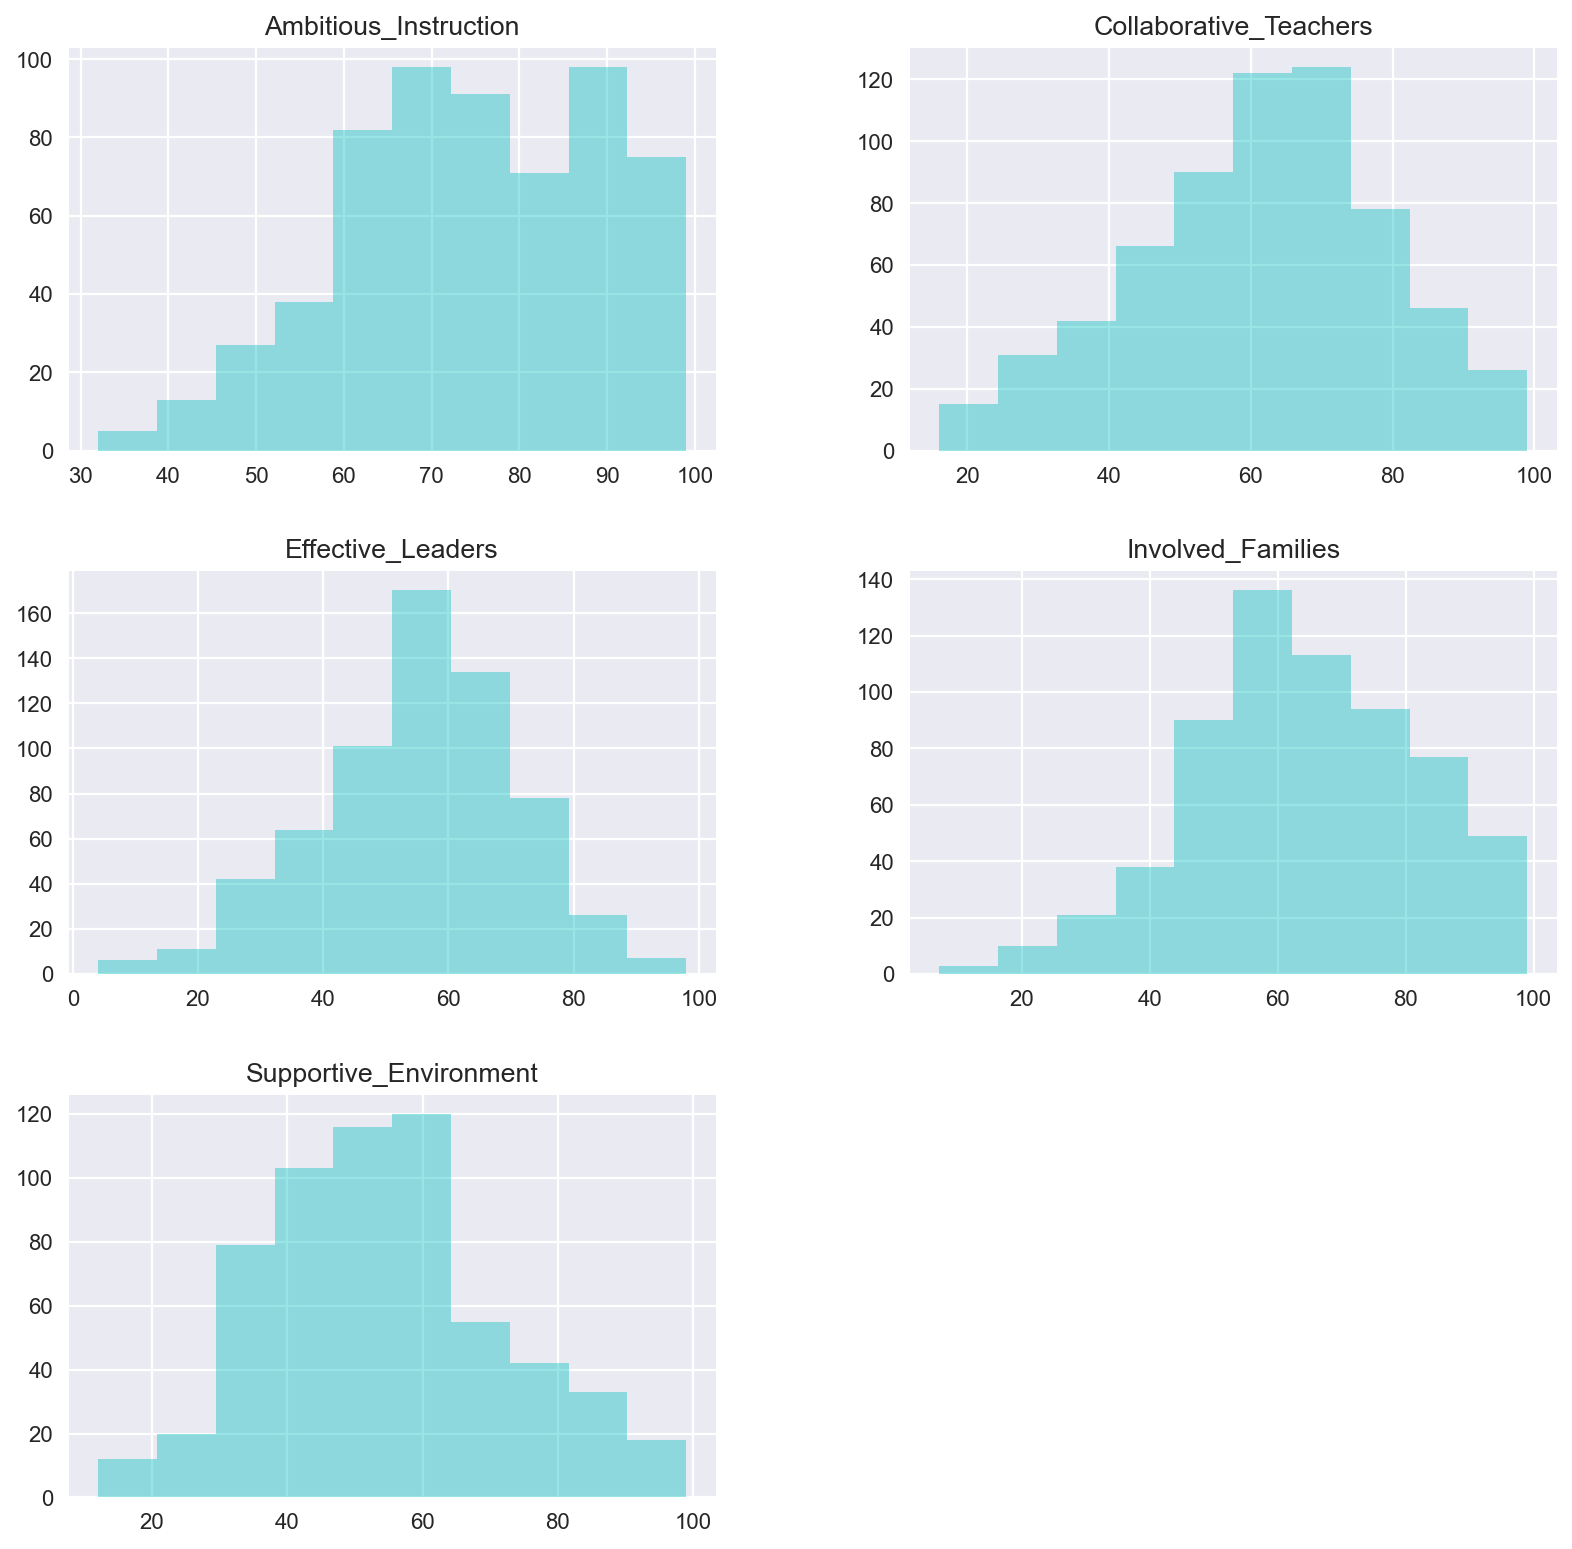

In [136]:
school_df.hist(figsize=(12,12), color='c', alpha=0.4);

In [139]:
columns = list(school_df.columns)